In [58]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
import os 
import mglearn
import re
import datetime
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [59]:

## prepare_weather_data 

WEATHER_DIR = './weather'
all_files = os.listdir(WEATHER_DIR)

data = pd.DataFrame()

for weather_file in all_files :

    if str(weather_file[-4:]) == '.csv' :

        file_path = os.path.join(WEATHER_DIR,str(weather_file))
        wdata = pd.read_csv(str(file_path),skiprows=range(16))
        data = data.append(wdata)



In [60]:
## remove feature with Nan and create timestamps for each sample

c = [i for i in data.columns if data.loc[:,i].count() != 0  and i!= 'Hmdx']
ndata = data[c]

def to_datetime(row) : 
    REGEX = '^([0-9]{4})-([0-9]{2})-([0-9]{2}) ([0-9]{2}).*$'
    m = re.match(REGEX,row)
    
    year = int(m.group(1))
    month = int(m.group(2))
    day = int(m.group(3))
    time =  int(m.group(4))
    
    return datetime.datetime(year,month,day,time,0,0)

ndata['Date/Time'] = ndata['Date/Time'].apply(to_datetime)
ndata['timestamp'] = ndata['Date/Time'].values.astype(np.int64)

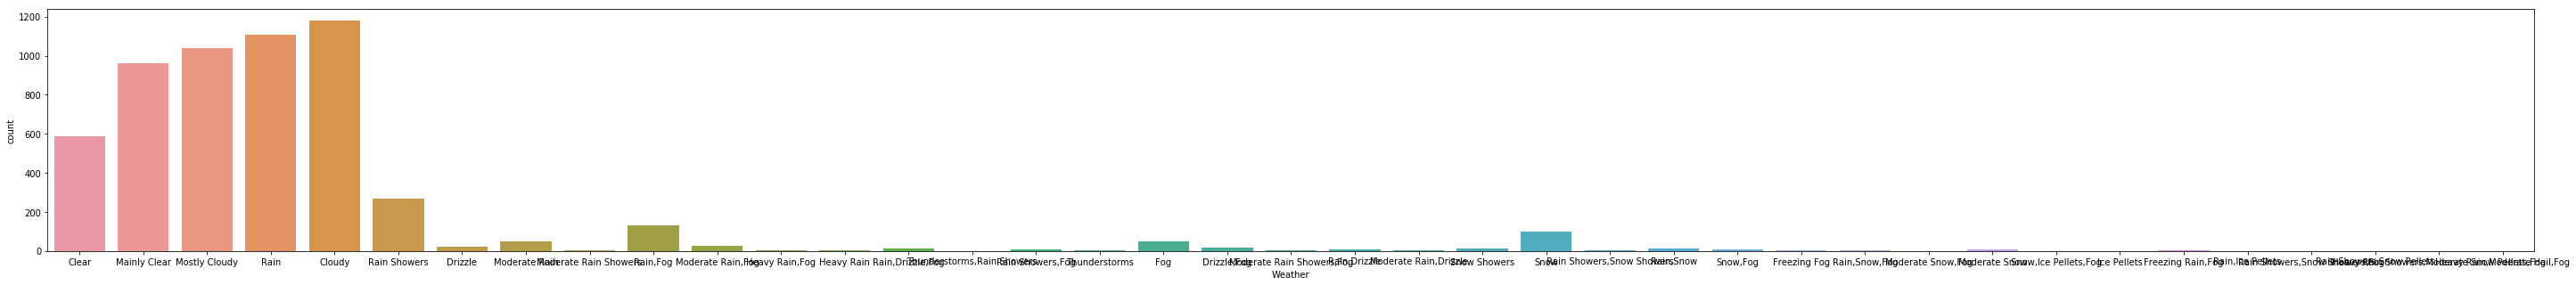

In [61]:
## shows unique weather category descritipion


weather_desc = pd.DataFrame(np.array(ndata['Weather'].unique()),columns=['WEATHER_DESC.'])
weather_desc
fig,ax = plt.subplots(figsize=(50,5))
x = sns.countplot(ax=ax,data=data,x=data['Weather'])
plt.savefig('plots/weather.jpg')

In [62]:
## FEATURE COMPARISON

def assign_colors(val) : 
    
    
    if val == 'Clear' : 
        color = 'pink'
    elif val == 'Mainly Clear' : 
        color = 'Orange'
    elif val == 'Mostly Cloudy' : 
        color = 'coral'
    elif val == 'Rain' : 
        color = 'Blue'
    elif val == 'Cloudy' : 
        color = 'dimgrey'
    elif val == 'Rain Showers' : 
        color = 'green'
    else : 
        color = 'gold'
    return color

ndata['color'] = ndata['Weather'].apply(assign_colors)
features = ndata[['Data Quality','Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)','Visibility (km)','Stn Press (kPa)']]


In [63]:
## FEATURE-ENGINEERING : CREATING 8 NEW FIELDS TO IDENTIFY DESCRIPTIONS SIMENTANEOUSLY
## Thunderstorms,drizzle are identified as rain category



def is_rain(val) : 
    REGEX1 = '^.*Rain.*$'
    REGEX2 = '^.*Drizzle.*$'
    REGEX3 = '^.*Thunderstorms.*$'
    if re.match(REGEX1,str(val)) is not None or re.match(REGEX2,str(val)) is not None or re.match(REGEX3,str(val)) is not None   : 
       
        return 1 
    else : 
        return 0
    
def is_clear(val) : 
    if re.match('^.*Clear.*$',str(val) )is not None : 
        return 1 
    else : 
        return 0

def is_snow(val) :
    if re.match('^.*Snow.*$',str(val) )is not None : 
        return 1 
    else : 
        return 0

def is_fog(val) : 
    if re.match('^.*Fog.*$',str(val) )is not None : 
        return 1 
    else : 
        return 0
    
def is_cloudy(val) : 
    if re.match('^.*Cloudy.*$',str(val) )is not None : 
        return 1 
    else : 
        return 0
    
    
def is_pellets(val) : 
    if re.match('^.*Pellets.*$',str(val) ) is not None : 
        return 1 
    else : 
        return 0

def new_weather_label(val) : 
    
    
    if val.is_pellets == 1 : 
        return 'Pellets'
    elif val.is_clear == 1 : 
        return 'Clear'
    elif val.is_rain == 1 : 
        return 'Rain'
    elif val.is_cloudy == 1 : 
        return 'Cloudy'
    elif val.is_fog == 1 : 
        return 'Fog'
    else : 
        return 'Unknown'
    


ndata['is_clear'] = ndata['Weather'].apply(is_clear)
ndata['is_snow'] = ndata['Weather'].apply(is_snow)
ndata['is_fog'] = ndata['Weather'].apply(is_fog)
ndata['is_cloudy'] = ndata['Weather'].apply(is_cloudy)
ndata['is_pellets'] = ndata['Weather'].apply(is_pellets)

ndata['is_rain'] = ndata['Weather'].apply(is_rain)


ldata = ndata[ndata['Weather'].isnull() == 0]
udata = ndata[ndata['Weather'].isnull() == 1]

ldata['x'] = ldata.apply(new_weather_label,axis=1)
ldata['x'].value_counts()


Cloudy     2220
Rain       1699
Clear      1548
Unknown     119
Fog          62
Pellets       5
Name: x, dtype: int64

In [64]:
## CRIME DATA

filename = 'crime_csv_all_years.csv'
cdata = pd.read_csv(filename)

years = ['2016','2017']

def year_specific(val) : 
    val = str(val)
    if val in years : 
        return val
    else : 
        return np.nan

to_string = lambda x:str(x)

def crime_datetime(row) : 
    year = int(row['YEAR'])
    month = int(row['MONTH'])
    day = int(row['DAY'])
    hour = int(row['HOUR'])
    return datetime.datetime(year,month,day,hour,0,0)


## only data from 2016 and 2015
cdata['YEAR'] = cdata['YEAR'].apply(to_string)
cdata['YEAR'] = cdata['YEAR'].apply(year_specific)
cdata = cdata.dropna(axis=0,how='any')

## Adding the timestamp
cdata['date/time'] = cdata.apply(crime_datetime,axis=1)
cdata['timestamp'] = cdata['date/time'].values.astype(np.int64)

In [65]:
joined_data = ldata.merge(cdata,on='timestamp')
joined_features = ['Date/Time','Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)','Visibility (km)','TYPE']
joined_data = joined_data[joined_features]




## multiple crimes are happening in the same time. So, we need to find a way to aggregate it. 

In [76]:
## image data 

def image_datetime(row) :
    year = int(row['year'])
    month = int(row['month'])
    day = int(row['day'])
    hour = int(row['hour'])

    return datetime.datetime(year,month,day,hour,0,0)


IMAGE_DIR = 'katkam-scaled'

contents = os.listdir(IMAGE_DIR)
filenames = pd.DataFrame(contents,columns=['title'])


filenames['year'] = filenames['title'].str.extract('katkam-([0-9]{4}).*\.jpg')
filenames['month'] = filenames['title'].str.extract('katkam-[0-9]{4}([0-9]{2}).*\.jpg')
filenames['day'] = filenames['title'].str.extract('katkam-[0-9]{4}[0-9]{2}([0-9]{2}).*\.jpg')
filenames['hour'] = filenames['title'].str.extract('katkam-[0-9]{4}[0-9]{2}[0-9]{2}([0-9]{2}).*\.jpg')

filenames['timestamp'] = filenames.apply(image_datetime,axis=1)
filenames['title'].count()

6991

In [116]:
## compiling sun_present and average color data

sun_present_file = 'image_data/SUN_PRESENT.csv'
sun_present = pd.read_csv(sun_present_file,header=None)
sun_present.columns =['image_index','sun_present']


#fig,ax = plt.subplots()
#sns.countplot(x=sun_present['sun_present'])

filenames['sun_present'] = sun_present['sun_present']
filenames

,title,year,month,day,hour,timestamp,sun_present
0,katkam-20160605060000.jpg,2016,06,05,06,2016-06-05 06:00:00,0
1,katkam-20160605070000.jpg,2016,06,05,07,2016-06-05 07:00:00,1
2,katkam-20160605080000.jpg,2016,06,05,08,2016-06-05 08:00:00,1
3,katkam-20160605090000.jpg,2016,06,05,09,2016-06-05 09:00:00,1
4,katkam-20160605100000.jpg,2016,06,05,10,2016-06-05 10:00:00,1
5,katkam-20160605110000.jpg,2016,06,05,11,2016-06-05 11:00:00,1
6,katkam-20160605120000.jpg,2016,06,05,12,2016-06-05 12:00:00,1
7,katkam-20160605130000.jpg,2016,06,05,13,2016-06-05 13:00:00,1
8,katkam-20160605140000.jpg,2016,06,05,14,2016-06-05 14:00:00,0
9,katkam-20160605150000.jpg,2016,06,05,15,2016-06-05 15:00:00,0
